In [ ]:
import time
import random
import copy

from enum import Enum
from typing import Tuple, Union

import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output

# GoMoKu simulator
- Gomoku is a popular game played in many countries. The player wins by having their pieces forming a straight-line connection with the length of 5 in an 8x8 board. The connection can be either horizontal, vertical or diagonal.

- However, in midterm project, the player **wins by having their symbol forming a connection with the length of 3 in 3x3 board**. The connection can be either horizontal, vertical or diagonal.

- **In the following blocks, Jupyter Notebook blocks are provided to define the necessary elements for implementing the Gomoku game. You can execute them one by one to become familiar with the components.**

Define datatye for game result

In [ ]:
class GameResult(Enum):
  """
  Enum to encode different states of the game. A game can be in progress (NOT_FINISHED), lost, won, or draw
  """
  NOT_FINISHED = 0
  NAUGHT_WIN = 1
  CROSS_WIN = 2
  DRAW = 3

Define board and game hyperparameter
- Board size
- The length of a connection for winning

In [ ]:
BOARD_DIM = 8 # type: int
BOARD_SIZE = BOARD_DIM * BOARD_DIM  # type: int
NUM_WIN = 5

Board consists of cells
- There are two symbols
  - Naught: O
  - Cross: X

In [ ]:
class CellState(Enum):
  EMPTY = 0  # type: int
  NAUGHT = 1  # type: int
  CROSS = 2  # type: int

Gomoku Board

In [ ]:
class GomokuBoard:
    """
    The class to encode a gomoku board, including its current state of pieces.
    Also contains various utility methods.
    """

    WIN_CHECK_DIRS = [[(-1, 0), (1, 0)],
                      [(0, -1), (0, 1)],
                      [(-1, 1), (1, -1)],
                      [(-1, -1), (1, 1)]]

    def hash_value(self) -> int:
        """
        Encode the current state of the game (board positions) as an integer. Will be used for caching evaluations
        :return: A collision free hash value representing the current board state
        """
        res = 0
        for i in range(BOARD_SIZE):
            res *= BOARD_DIM
            res += self.state[i].value

        return res

    @staticmethod
    def other_side(side: CellState) -> CellState:
        """
        Utility method to return the value of the other player than the one passed as input
        :param side: The side we want to know the opposite of
        :return: The opposite side to the one passed as input
        """
        if side == CellState.EMPTY:
            raise ValueError("EMPTY has no 'other side'")

        if side == CellState.CROSS:
            return CellState.NAUGHT

        if side == CellState.NAUGHT:
            return CellState.CROSS

        raise ValueError("{} is not a valid side".format(side))

    def __init__(self):
        """
        Create a new Board. If a state is passed in, we use that otherwise we initialize with an empty board
        :param s: Optional board state to initialise the board with
        """
        self.state = np.ndarray(shape=(BOARD_SIZE,), dtype=CellState)
        self.reset()

    def coord_to_pos(self, coord: Tuple[int, int]) -> int:
        """
        Converts a 2D board position to a 1D board position.
        Various parts of code prefer one over the other.
        :param coord: A board position in 2D coordinates
        :return: The same board position in 1D coordinates
        """
        return coord[0] * BOARD_DIM + coord[1]

    def pos_to_coord(self, pos: int) -> Tuple[int, int]:
        """
        Converts a 1D board position to a 2D board position.
        Various parts of code prefer one over the other.
        :param pos: A board position in 1D coordinates
        :return: The same board position in 2D coordinates
        """
        return pos // BOARD_DIM, pos % BOARD_DIM

    def reset(self):
        """
        Resets the game board. All fields are set to be EMPTY.
        """
        self.state.fill(CellState.EMPTY)
        self.who_won = None

    def num_empty(self) -> int:
        """
        Counts and returns the number of empty fields on the board.
        :return: The number of empty fields on the board
        """
        return np.count_nonzero(self.state == CellState.EMPTY)

    def random_empty_spot(self) -> int:
        """
        Returns a random empty spot on the board in 1D coordinates
        :return: A random empty spot on the board in 1D coordinates
        """
        index = np.random.randint(self.num_empty()) # Count all empty spot and random selection among them
        for i in range(BOARD_SIZE):
            if self.state[i] == CellState.EMPTY:
                if index == 0: # if index is zero, then, it means this spot is selected
                    return i
                else:
                    index = index - 1 # if index is not zero, then, it means we have to move next emtpy spot

    def is_legal(self, pos: int) -> bool:
        """
        Tests whether a board position can be played, i.e. is currently empty
        :param pos: The board position in 1D that is to be checked
        :return: Whether the position can be played
        """
        return (0 <= pos < BOARD_SIZE) and (self.state[pos] == CellState.EMPTY)

    def move(self, position: int, side: CellState) -> Union[np.ndarray, GameResult, bool]:
        """
        Places a piece of side "side" at position "position". The position is to be provided as 1D.
        Throws a ValueError if the position is not EMPTY
        returns the new state of the board, the game result after this move, and whether this move has finished the game

        :param position: The position where we want to put a piece
        :param side: What piece we want to play (NAUGHT, or CROSS)
        :return: The game state after the move, The game result after the move, Whether the move finished the game
        """
        if self.state[position] != CellState.EMPTY:
            print('Illegal move')
            raise ValueError("Invalid move")

        self.state[position] = side

        if self.check_win(position, side):
            self.who_won = side
            return self.state, GameResult.CROSS_WIN if side == CellState.CROSS else GameResult.NAUGHT_WIN, True

        if self.num_empty() == 0:
            self.who_won = CellState.EMPTY
            return self.state, GameResult.DRAW, True

        return self.state, GameResult.NOT_FINISHED, False

    def check_win(self, pos: int, side: CellState):
        row = pos // BOARD_DIM
        col = pos % BOARD_DIM

        def check_direction(_dr, _dc):
            count = 0
            r, c = row + _dr, col + _dc
            p = r * BOARD_DIM + c
            while 0 <= r < BOARD_DIM and 0 <= c < BOARD_DIM and self.state[p] == side:
                count += 1
                r += _dr
                c += _dc
                p = r * BOARD_DIM + c
            return count

        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]

        for dr, dc in directions:
            total_count = 1  # Count the current stone
            total_count += check_direction(-dr, -dc)  # Count stones in the opposite direction
            total_count += check_direction(dr, dc)    # Count stones in the original direction

            if total_count >= NUM_WIN:
                return True

        return False

    def state_to_char(self, pos):
        """
        Return 'x', 'o', or ' ' depending on what piece is on 1D position pos. Ig `html` is True,
        return '&ensp' instead of ' ' to enforce a white space in the case of HTML output
        :param pos: The position in 1D for which we want a character representation
        :param html: Flag indicating whether we want an ASCII (False) or HTML (True) character
        :return: 'x', 'o', or ' ' depending on what piece is on 1D position pos. Ig `html` is True,
        return '&ensp' instead of ' '
        """
        if (self.state[pos]) == CellState.NAUGHT:
            return 'O'
        elif (self.state[pos]) == CellState.CROSS:
            return 'X'

Visualizing a board
- Clear all figures and prints before drawing a board


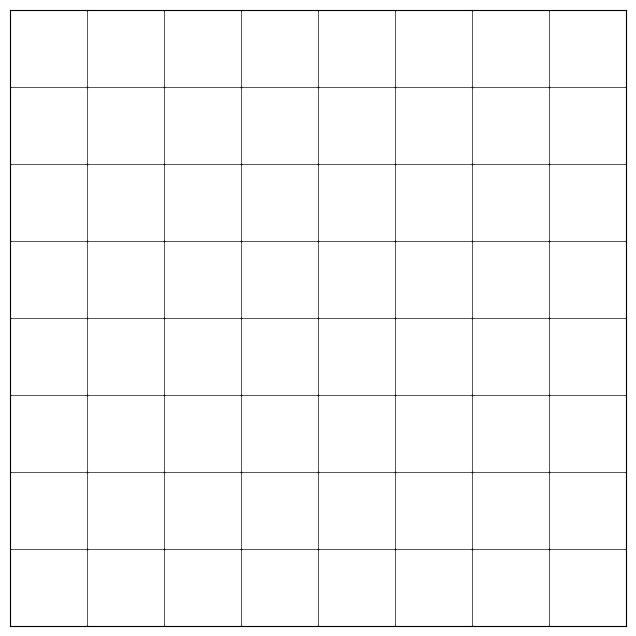

In [ ]:
def draw_go_board(board: GomokuBoard):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(BOARD_DIM, BOARD_DIM))
    ax.set_xlim(0, BOARD_DIM)
    ax.set_ylim(0, BOARD_DIM)

    cell_size = 0.97
    rect_offset = (1.-cell_size) / 2  # Offset to center the cells
    offset = 1 / 2

    # Draw black board
    ax.add_patch(plt.Rectangle((0, 0), BOARD_DIM, BOARD_DIM, color='black', fill=True))

    # Draw white cells
    for x in range(BOARD_DIM):
        for y in range(BOARD_DIM):
            ax.add_patch(plt.Rectangle((x + rect_offset, y + rect_offset), cell_size, cell_size, color='white', fill=True))

    # Place markers
    for x in range(BOARD_DIM):
        for y in range(BOARD_DIM):
            pos = x * BOARD_DIM + y
            marker = board.state_to_char(pos)
            ax.text(x + offset, y + offset, marker, ha='center', va='center', fontsize=20)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
    time.sleep(0.5)

board = GomokuBoard()
draw_go_board(board)

Select an empty cell from random policy
- It means that a random policy is given!

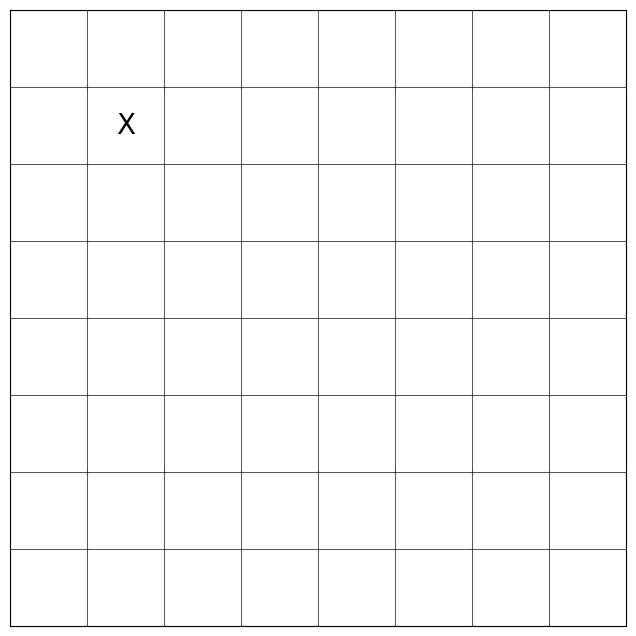

In [ ]:
location = board.random_empty_spot()
_, res, finished = board.move(int(location), CellState.CROSS)
draw_go_board(board)

Check winning conditions!
- Board class has a _move method_ whose inputs are "location and side" and outpus are "results of game and finish or not"



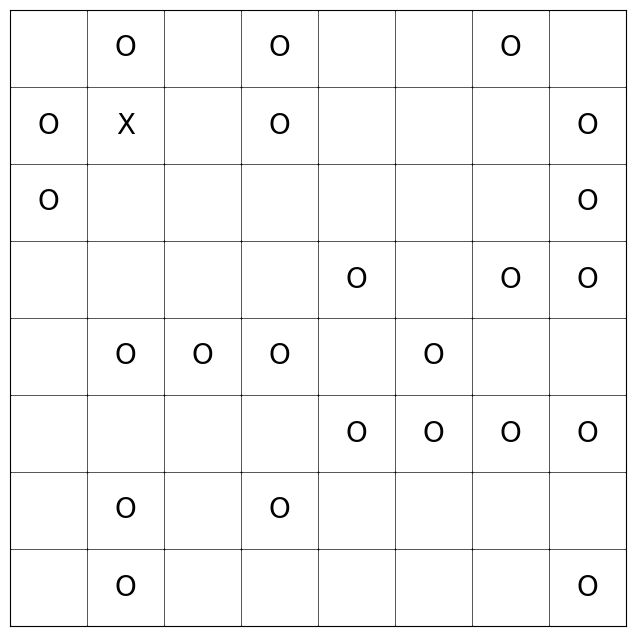

GameResult.NAUGHT_WIN


In [ ]:
finished = False
while not finished:
    location = board.random_empty_spot()
    _, res, finished = board.move(int(location), CellState.NAUGHT)
    draw_go_board(board)
    print(res)

# Agent class definition

- The provided class, **GamePlayerInterface**, is an abstract class in Python, defined using the ABC (Abstract Base Class) module.
This class serves as an interface or template for implementing Gomoku players in a Gomoku game. Let's break down the key components and purpose of this class:

- Abstract Methods: The GamePlayerInterface class contains several abstract methods, indicated by the @abstractmethod decorator. Abstract methods are methods that are declared but not implemented in the base class. Instead, derived classes must provide concrete implementations for these methods. Let's go through each of the abstract methods:

  - _move(self, board: GomokuBoard) -> Union[GameResult, bool]_:
  
   This method represents the player's move in the Gomoku game. It takes a GomokuBoard object as a parameter, which likely represents the current state of the game board. The method returns either a GameResult or a boolean value. The GameResult may represent the outcome of the game after the move, such as a win or a draw. The boolean value may indicate whether the move was successful.

  - _new_game(self, side: CellState)_:

   This method is meant to be called when a new game of Gomoku is starting. It takes a side parameter, which likely represents the player's side or symbol (e.g., 'X' or 'O'). Derived classes should implement this method to prepare for a new game.

In [ ]:
from abc import ABC, abstractmethod

class GamePlayerInterface(ABC):
    """
    Interface for Gomoku player
    """
    def __init__(self):
        super().__init__()

    @abstractmethod
    def move(self, board: GomokuBoard) -> Union[GameResult, bool]:
        pass

    @abstractmethod
    def new_game(self, side: CellState):
        pass

Example: random agent!

In [ ]:
class RandomPlayer(GamePlayerInterface):
    def __init__(self):
        # Initialize the player's side to None
        self.side = None
        super().__init__()

    def move(self, GomokuBoard: GomokuBoard) -> Union[GameResult, bool]:
        # Get a random empty spot on the game board
        location = GomokuBoard.random_empty_spot()

        # Make a move on the game board and capture the result and whether the game is finished
        _, res, finished = GomokuBoard.move(int(location), self.side)

        # Return the move's result and whether the game is finished
        return res, finished

    def new_game(self, side: CellState):
        # Set the player's side at the start of a new game
        self.side = side

Helper functions

1. Play a game
   - This function simulates a single Gomoku game between two players represented by the player1 and player2 objects, using the game board provided as board.

   - It starts by initializing the players for a new game, with player1 taking the 'CROSS' side and player2 taking the 'NAUGHT' side.

   - The game board is reset to an empty state.

   - The function enters a loop where the players take turns making moves on the board until the game is finished. After each move, if the drawing_board parameter is set to True, it also visualizes the current state of the game board using the draw_go_board function (which is assumed to be defined elsewhere).

   - The function returns the result of the game (whether 'CROSS' or 'NAUGHT' won or if it's a draw).
2. Battle

   - This function simulates a series of Gomoku games between two players, player1 and player2, for a specified number of games (num_games).

   - It initializes a Gomoku board for each game and keeps track of the number of wins for 'CROSS' (player1), 'NAUGHT' (player2), and draws.

   - The games are played by calling the play_game function repeatedly with the provided players.

   - After all games are played, the function prints out the results, including the number of draws, wins for 'CROSS' (player1), and wins for 'NAUGHT' (player2). If the silent parameter is set to True, it doesn't print the results.

   - The function also calculates and prints the percentages of draws and wins for each player based on the total number of games played.

In [ ]:
def play_game(board: GomokuBoard, player1: GamePlayerInterface, player2: GamePlayerInterface, drawing_board: bool = True):
    player1.new_game(CellState.CROSS)
    player2.new_game(CellState.NAUGHT)
    board.reset()

    finished = False
    while not finished:
        result, finished = player1.move(board)
        if drawing_board:
            draw_go_board(board)
        if finished:
            continue
        else:
            result, finished = player2.move(board)
            if drawing_board:
                draw_go_board(board)
    return result

def battle(player1: GamePlayerInterface, player2: GamePlayerInterface, num_games: int = 1000, silent: bool = False):
    board = GomokuBoard()
    draw_count = 0
    cross_count = 0
    naught_count = 0
    for _ in range(num_games):
        result = play_game(board, player1, player2,drawing_board=False)
        if result == GameResult.CROSS_WIN:
            cross_count += 1
        elif result == GameResult.NAUGHT_WIN:
            naught_count += 1
        else:
            draw_count += 1

    if not silent:
        print("After {} game we have draws: {}, GamePlayerInterface 1 wins: {}, and GamePlayerInterface 2 wins: {}.".format(num_games, draw_count,
                                                                                                  cross_count,
                                                                                                  naught_count))

        print("Which gives percentages of draws: {:.2%}, GamePlayerInterface 1 wins: {:.2%}, and GamePlayerInterface 2 wins:  {:.2%}".format(
            draw_count / num_games, cross_count / num_games, naught_count / num_games))

    return cross_count, naught_count, draw_count

Run _play_game_ function!

- Random Policy vs. Random Policy

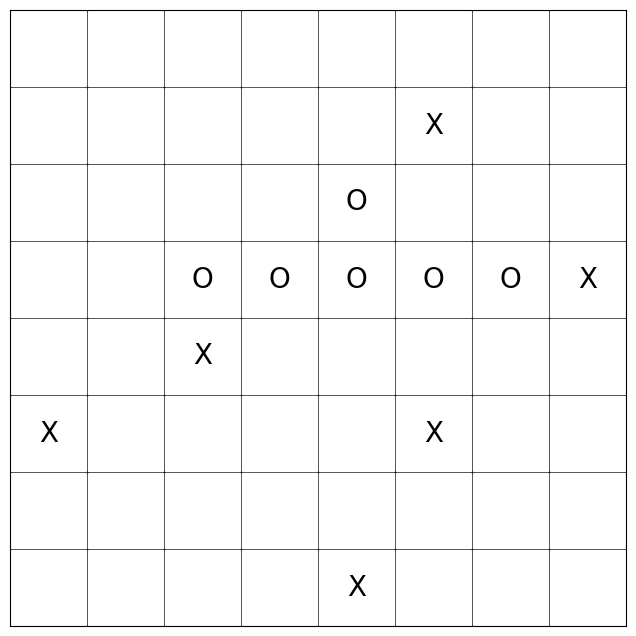

GameResult.NAUGHT_WIN


In [ ]:
board = GomokuBoard()
player1 = RandomPlayer()
player2 = best()
result = play_game(board, player1, player2)
print(result)

Estiamte win rate using battle function!
- It reports the average win rate among 1000 games

In [ ]:
board = GomokuBoard()
player1 = RandomPlayer()
player2 = best()
cross_count, naught_count, draw_count = battle(player1, player2, )

# Implement Monte-Carlo Tree Search!!!

**The instructions and skeletones are just guide line**

Here are the instructions for each part of the provided skeleton code in bullet points:

WIN_VALUE, DRAW_VALUE, and LOSS_VALUE are class constants representing the values for winning, drawing, and losing.
The class constructor __init__ initializes the side as None and creates an empty directed graph using NetworkX.
The new_game function sets the side for the player and clears the game tree.
The final_result function does nothing but is required by the GamePlayerInterface.

'simulate_game' Function:

This function simulates a game between two random players and returns the result as an integer (WIN_VALUE, LOSS_VALUE, or DRAW_VALUE).

'find_optimal_move' Function:

find_optimal_move takes two parameters: current_node, a graph node, and find_max, a boolean indicating whether to find the maximum or minimum value.
It retrieves the successors of the current_node in the game tree.
Initializes best_score with negative infinity for maximizing players and positive infinity for minimizing players.
Iterates through successors and calculates the evaluation score for each edge.
For maximizing players, updates best_score if a higher score is found, and for minimizing players, updates best_score if a lower score is found.
Collects all moves that have the best score.
Randomly selects one move from the list of best moves.
Returns the best_score and the selected best move.

'_min' Function:

_min evaluates the board position from the minimizing player's perspective.
It first checks if the game has ended and returns the corresponding result.
If the game is ongoing, it checks if the current board position exists in the game tree. If not, it expands the tree with possible moves.
Calculates UCB (Upper Confidence Bound) scores for each edge.
Selects the edge with the minimum UCB score.
Simulates games to estimate the value of the selected edge.
Updates the edge's weight with the estimated value.
Calls find_optimal_move to find the optimal move for the minimizing player.
Returns the minimum value and the optimal move.

'_max' Function:

_max evaluates the board position from the maximizing player's perspective.
It follows a similar structure to _min but focuses on maximizing player moves.
Calculates UCB scores for each edge, selects the edge with the maximum UCB score.
Simulates games to estimate the value of the selected edge.
Updates the edge's weight with the estimated value.
Calls find_optimal_move to find the optimal move for the maximizing player.
Returns the maximum value and the optimal move.

'move' Function:

The move function implements the main logic of the Monte Carlo Tree Search algorithm for making a move in a game.
It repeatedly calls the _max function to search for the optimal move within a limited number of iterations (in this case, 200 iterations).
The _max function explores and evaluates possible moves and selects the best move.
Finally, the move function returns the result of the selected move and whether the game has finished.

#Requirements

1. Submission Requirements
- You need to submit your class as a .py file
- **Your file must contain 'GamePlayerInterface' and 'MCTSAlgorithm'**
- You can import any other libraries and add any other classes in your file
- Do not employ any other libraries for tree search algorithm except for "networkx"
- The Python file should be named with your student number, like this: mcts_[student_number].py
- It should be importable and usable as follows:
```
import mcts_[student_number]
player1 = mcts_[student_number].MCTSAlgorithm()
```
- For example, if your student number is 12345, then,
  - Your submission must be "mcts_12345.py"
  - We can import your file as follows,
  ```
  import mcts_12345
  player1 = mcts_12345.MCTSAlgorithm()
  ```

2. Performance Requirements

  You can check the performance of the implemented tree search using the battle function. The implemented mcts should meet the following requirements when competing against a random policy:

- Computation time of MCTS
- When battling as player1 with random policy, achieve a win rate of 60% or higher (excluding draws)
- When battling as player2 with random policy, have a 40% probability of losing

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import networkx as nx
import copy

class GamePlayerInterface(ABC):

    def __init__(self):
        super().__init__()

    @abstractmethod
    def move(self, board):
        pass

    @abstractmethod
    def new_game(self, side):
        pass

class MCTSAlgorithm(GamePlayerInterface):

    WIN_VALUE = 1
    DRAW_VALUE = 0
    LOSS_VALUE = -1

    def __init__(self, c=1.414, epoch=750, simul_num=30):
        super().__init__()
        self.side = None
        self.tree = nx.DiGraph()
        self.C = c
        self.epoch = epoch
        self.simul_num = simul_num

    def new_game(self, side):
        self.side = side
        self.tree.clear()

    def check_num(self, move, side, original_state):
        four_stones = []
        row = move//8
        col = move%8
        finish = False

        def check_direction(_dr, _dc):
            count = 0
            r, c = row + _dr, col + _dc
            p = r * 8 + c
            indices = []
            margin = 2
            while 0 <= r < 8 and 0 <= c < 8 and original_state[p] == side:
                count += 1
                r += _dr
                c += _dc
                p = r * 8 + c
            while 0 <= r < 8 and 0 <= c < 8 and original_state[p].value == 0 and margin:
                margin-=1
                indices.append(p)
                r += _dr
                c += _dc
                p = r * 8 + c
            return count, indices

        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]

        for dr, dc in directions:
            total_count = 1
            count_1, indices_1 = check_direction(-dr, -dc)
            count_2, indices_2 = check_direction(dr, dc)
            total_count += count_1
            total_count += count_2

            if total_count >= 5:
                finish = True
                return finish, four_stones

            if total_count == 4 and indices_1 and indices_2:
                four_stones+=indices_1
                four_stones+=indices_2

        return finish, four_stones

    def move(self, board):
        root_hash = board.hash_value()
        original_state = board.state.copy()
        numeric_state = np.vectorize(lambda x: x.value)(original_state)
        empty_indices = np.flatnonzero(numeric_state == 0)
        possible_moves = len(empty_indices)
        opp_side = board.other_side(self.side)

        init_guid = []
        very_urgent = []
        urgency = []

        if possible_moves == 64:
            location = 28
            _, res, finished = board.move(location, self.side)
            return res, finished

        if 64-1 >= possible_moves >= 64-3:
            locked_indices = [index for index in range(64) if index not in empty_indices]
            for move in locked_indices:
                rr, cc = move//8, move%8
                for dx in range(-2,3):
                    nr = rr+dx
                    if 0<=nr<8:
                        for dy in range(-2,3):
                            nc = cc+dy
                            if 0<=nc<8:
                                init_guid.append(nr*8+nc)
            empty_indices = [item for item in set(init_guid) if item not in locked_indices]

        if possible_moves<=64-5:
            for move in empty_indices:
                finish, four_stones = self.check_num(move, self.side, original_state)
                if finish:
                    _, res, finished = board.move(move, self.side)
                    return res, finished
                if four_stones:
                    urgency.append(move)
                    urgency+=four_stones

                finish, four_stones = self.check_num(move, opp_side, original_state)
                if finish:
                    very_urgent.append(move)
                if four_stones:
                    urgency.append(move)
                    urgency+=four_stones

            urgency = list(set(urgency))
            if len(very_urgent)==1:
                move = very_urgent[0]
                _, res, finished = board.move(move, self.side)
                return res, finished

        if very_urgent:
            empty_indices = very_urgent
        elif urgency:
            empty_indices = urgency

        self.tree.add_node(root_hash, total_return=0, N = possible_moves * self.simul_num, index=None)

        for index in empty_indices:
            new_hash = root_hash + self.side.value * 8**(63-int(index))
            self.tree.add_node(new_hash, total_return=0, N = self.simul_num, index = index)
            self.tree.add_edge(root_hash, new_hash)
            result = 0
            for _ in range(self.simul_num):
                res = self.simulate(board, index)
                result += res
                board.state[:] = original_state
            self.tree.nodes[new_hash]['total_return'] += result

        for _ in range(self.epoch-possible_moves):
            selected_node_hash = self.select(root_hash)
            location =  self.tree.nodes[selected_node_hash]['index']
            result = 0
            for _ in range(self.simul_num):
                res = self.simulate(board, location)
                result += res
                board.state[:] = original_state
            self.tree.nodes[selected_node_hash]['total_return'] += result
            self.tree.nodes[selected_node_hash]['N'] += self.simul_num
            self.tree.nodes[root_hash]['N'] += self.simul_num

        best_move, best_value = None, float('-inf')
        for child_hash in self.tree.successors(root_hash):
            child_node = self.tree.nodes[child_hash]
            value = child_node['total_return'] / child_node['N']
            if value > best_value:
                best_move, best_value = child_node['index'], value
        _, res, finished = board.move(best_move, self.side)
        return res, finished

    def select(self,root_hash):
        ucb_values = []
        root_hash_data_N = self.tree.nodes[root_hash]['N']
        for child_hash in self.tree.successors(root_hash):
            ucb_value = self.calculate_ucb(child_hash, root_hash_data_N)
            ucb_values.append((child_hash, ucb_value))
        best_hash = max(ucb_values, key=lambda x: x[1])[0]
        return best_hash

    def calculate_ucb(self, node_hash, root_hash_data_N):
        node_data = self.tree.nodes[node_hash]
        visit = node_data['N']
        total_return = node_data['total_return']
        ucb_value = (total_return / visit) + self.C * np.sqrt(2 * np.log(root_hash_data_N) / (visit))
        return ucb_value

    def simulate(self, board, location):
        side = self.side
        _, res, finished = board.move(location, side)
        step = 0
        while not finished:
           location = board.random_empty_spot()
           side = board.other_side(side)
           _, res, finished = board.move(location, side)
           step +=1
        if res.value != 3:
            res = 1 if (self.side.value == res.value) else -1
            return res * 0.998**step
        return 0

In [ ]:
player1 = MCTSAlgorithm()
player2 = MCTSAlgorithm()
cross_count, naught_count, draw_count = battle(player1, player2, num_games=40)

After 40 game we have draws: 5, GamePlayerInterface 1 wins: 3, and GamePlayerInterface 2 wins: 32.
Which gives percentages of draws: 12.50%, GamePlayerInterface 1 wins: 7.50%, and GamePlayerInterface 2 wins:  80.00%


In [ ]:
player2 = MCTSAlgorithm()
player1 = MCTSAlgorithm()
cross_count, naught_count, draw_count = battle(player1, player2, num_games=40)